In [1]:
# Block 2 (Updated)
!pip install -q "numpy<2.0" "scipy<1.14" "albumentations==1.3.0" ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [2]:
from ultralytics import YOLO

YOLO_WEIGHTS = "/kaggle/input/yolov11n-seg-weights/pytorch/default/1/yolo11n-seg.pt"

yolo = YOLO(YOLO_WEIGHTS)
print("YOLOv11n-seg model loaded successfully!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv11n-seg model loaded successfully!


In [3]:
# # ==========================
# # BLOCK 1 — PREPROCESSING & SAVING
# # ==========================
# import os
# import json
# import math
# import random
# import shutil
# from pathlib import Path
# from collections import defaultdict
# import numpy as np
# import cv2
# from tqdm import tqdm

# # -----------------------------------------
# # DEPENDENCIES
# # -----------------------------------------
# import albumentations as A
# from ultralytics import YOLO

# # -----------------------------------------
# # CONFIG
# # -----------------------------------------
# INPUT_ROOT = Path("/kaggle/input/face-sideview-kp/train")
# COCO_JSON = INPUT_ROOT / "_annotations.coco.json"

# YOLO_WEIGHTS = Path(
#     "/kaggle/input/yolov11n-seg-weights/pytorch/default/1/yolo11n-seg.pt"
# )

# OUTPUT_ROOT = Path("/kaggle/working/preprocessed")
# BASE_OUT = OUTPUT_ROOT / "train"
# BASE_IM_OUT = BASE_OUT / "images"
# BASE_JSON = BASE_OUT / "annotations.json"
# BASE_NPZ = BASE_OUT / "annotations.npz"

# AUG_OUT = OUTPUT_ROOT / "augmented/train"
# AUG_IM_OUT = AUG_OUT / "images"
# AUG_JSON = AUG_OUT / "annotations.json"
# AUG_NPZ = AUG_OUT / "annotations.npz"

# TARGET_SIZE = 512
# MARGIN_RATIO = 0.25         # head-margin for initial bbox crop
# N_AUG = 20
# SEED = 42

# # Clean and create directories
# if OUTPUT_ROOT.exists():
#     shutil.rmtree(OUTPUT_ROOT)

# os.makedirs(BASE_IM_OUT, exist_ok=True)
# os.makedirs(AUG_IM_OUT, exist_ok=True)

# random.seed(SEED)
# np.random.seed(SEED)

# # -----------------------------------------
# # Load COCO annotations
# # -----------------------------------------
# with open(COCO_JSON, "r") as f:
#     coco = json.load(f)

# images_info = {im["id"]: im for im in coco["images"]}
# anns_by_image = defaultdict(list)
# for ann in coco["annotations"]:
#     anns_by_image[ann["image_id"]].append(ann)

# # Safety check for keypoint length
# if coco["annotations"]:
#     KP_LEN = len(coco["annotations"][0]["keypoints"]) // 3
# else:
#     KP_LEN = 0

# # -----------------------------------------
# # Load YOLO model
# # -----------------------------------------
# if YOLO_WEIGHTS.exists():
#     yolo = YOLO(str(YOLO_WEIGHTS))
# else:
#     print("Weights not found, downloading fallback...")
#     yolo = YOLO("yolov8n-seg.pt")


# # -----------------------------------------
# # UTILS: YOLO Segmentation & Cropping
# # -----------------------------------------
# def get_black_bg(img_bgr):
#     """Segment person, invert mask so background is 1, set background to black."""
#     h, w = img_bgr.shape[:2]
#     results = yolo(img_bgr, verbose=False, retina_masks=True)
    
#     # Fallback if no detection
#     if not results or not results[0].masks:
#         return img_bgr.copy(), np.ones((h, w), dtype=np.uint8)

#     r = results[0]
#     masks = r.masks.data.cpu().numpy()
#     boxes = r.boxes
#     cls_arr = boxes.cls.cpu().numpy()
    
#     # Filter for 'person' class (index 0)
#     person_idxs = [i for i, c in enumerate(cls_arr) if int(c) == 0]
#     if not person_idxs:
#         return img_bgr.copy(), np.ones((h, w), dtype=np.uint8)

#     # Pick largest person
#     best_i, best_area = None, -1
#     for i in person_idxs:
#         m = masks[i]
#         if m.shape != (h, w):
#             m = cv2.resize((m > 0.5).astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
#         area = m.sum()
#         if area > best_area:
#             best_area = area
#             best_i = i

#     pmask = masks[best_i]
#     if pmask.shape != (h, w):
#         pmask = cv2.resize((pmask > 0.5).astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
#     else:
#         pmask = (pmask > 0.5).astype(np.uint8)

#     # Invert: Background=1, Person=0
#     bg_mask = (1 - pmask).astype(np.uint8)
#     out = img_bgr.copy()
#     out[bg_mask == 1] = 0
#     return out, bg_mask

# def square_bbox_with_margin(bbox, img_w, img_h, margin_ratio):
#     x, y, w, h = bbox
#     cx = x + w/2
#     cy = y + h/2
#     side = max(w, h)
#     pad = side * margin_ratio
#     side2 = side + 2*pad
#     x1 = int(cx - side2/2)
#     y1 = int(cy - side2/2)
#     x2 = int(cx + side2/2)
#     y2 = int(cy + side2/2)
#     return x1, y1, x2, y2

# def expand_crop_to_include_all_kps(initial_crop, keypoints, img_w, img_h, margin_px=8):
#     x1, y1, x2, y2 = initial_crop
#     xs = [keypoints[i] for i in range(0, len(keypoints), 3) if keypoints[i+2] > 0]
#     ys = [keypoints[i+1] for i in range(0, len(keypoints), 3) if keypoints[i+2] > 0]

#     if not xs: return x1, y1, x2, y2

#     min_x, max_x = min(xs) - margin_px, max(xs) + margin_px
#     min_y, max_y = min(ys) - margin_px, max(ys) + margin_px

#     x1_new = min(x1, int(min_x))
#     y1_new = min(y1, int(min_y))
#     x2_new = max(x2, int(max_x))
#     y2_new = max(y2, int(max_y))

#     # Make square
#     w_new, h_new = x2_new - x1_new, y2_new - y1_new
#     side = max(w_new, h_new)
#     cx, cy = x1_new + w_new//2, y1_new + h_new//2
#     half = side // 2
    
#     return int(cx - half), int(cy - half), int(cx + half), int(cy + half)

# # -----------------------------------------
# # AUGMENTATION PIPELINE
# # -----------------------------------------
# aug = A.Compose(
#     [
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.2),
#         A.ShiftScaleRotate(shift_limit=0.10, scale_limit=0.10, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.8),
#         A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.5, p=0.6),
#         A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
#         A.CoarseDropout(max_holes=6, max_height=48, max_width=48, min_holes=1, min_height=8, min_width=8, p=0.3),
#     ],
#     keypoint_params=A.KeypointParams(format="xy", remove_invisible=False)
# )

# -----------------------------------------
# MAIN PROCESSING LOOP (UNCOMMENTED)
# -----------------------------------------
# processed_entries = []
# aug_entries = []

# print("Starting preprocessing...")

# for img_id, imginfo in tqdm(images_info.items()):
#     img_name = imginfo["file_name"]
#     img_path = INPUT_ROOT / img_name
    
#     if not img_path.exists():
#         # Try alternate path if file not found
#         alt = INPUT_ROOT / Path(img_name).name
#         img_path = alt if alt.exists() else None
#         if not img_path: continue

#     img_bgr = cv2.imread(str(img_path))
#     if img_bgr is None: continue

#     h, w = img_bgr.shape[:2]
#     anns = anns_by_image[img_id]
#     if not anns: continue
    
#     ann = max(anns, key=lambda a: a["area"])
#     bbox = ann["bbox"]
#     kps = ann["keypoints"]

#     # 1) Background Black
#     img_blackbg, _ = get_black_bg(img_bgr)

#     # 2) Initial Crop
#     x1, y1, x2, y2 = square_bbox_with_margin(bbox, w, h, MARGIN_RATIO)

#     # 3) Expand Crop for KPs
#     x1, y1, x2, y2 = expand_crop_to_include_all_kps((x1, y1, x2, y2), kps, w, h)

#     # 4) Handle Padding (if crop is outside image bounds)
#     pad_l, pad_t = max(0, -x1), max(0, -y1)
#     pad_r, pad_b = max(0, x2 - w), max(0, y2 - h)

#     if pad_l or pad_t or pad_r or pad_b:
#         img_blackbg = cv2.copyMakeBorder(
#             img_blackbg, pad_t, pad_b, pad_l, pad_r,
#             cv2.BORDER_CONSTANT, value=(0,0,0)
#         )
#         x1 += pad_l
#         y1 += pad_t
#         x2 += pad_l
#         y2 += pad_t

#     # 5) Crop
#     crop = img_blackbg[y1:y2, x1:x2].copy()
#     if crop.size == 0: continue

#     # 6) Ensure Square (internal padding)
#     ch, cw = crop.shape[:2]
#     if ch != cw:
#         side = max(ch, cw)
#         pt, pb = (side - ch)//2, side - ch - (side - ch)//2
#         pl, pr = (side - cw)//2, side - cw - (side - cw)//2
#         crop = cv2.copyMakeBorder(crop, pt, pb, pl, pr, cv2.BORDER_CONSTANT, value=(0,0,0))

#     # 7) Resize & Grayscale
#     resized = cv2.resize(crop, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)
#     gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

#     # 8) Normalize Keypoints
#     crop_w, crop_h = x2 - x1, y2 - y1
#     kps_norm = []
    
#     # We must account for the initial padding we added to the image (pad_l, pad_t)
#     # The crop coordinates (x1, y1) are already shifted by pad_l, pad_t in step 4
#     # The raw keypoints need to be shifted by pad_l, pad_t too before subtracting crop origin.
#     for i in range(0, len(kps), 3):
#         xkp, ykp, v = kps[i], kps[i+1], kps[i+2]
#         if v == 0:
#             kps_norm.extend([0.0, 0.0, 0])
#             continue
        
#         # Shift keypoint to padded image space
#         xr = (xkp + pad_l) - x1
#         yr = (ykp + pad_t) - y1
        
#         # Simple bounds check
#         # Note: crop_w is used here because internal padding (step 6) centers the image, 
#         # making exact kp math complex. For simplicity, we assume crop covered KPs largely.
#         if xr < 0 or xr > crop_w or yr < 0 or yr > crop_h:
#             kps_norm.extend([0.0, 0.0, 0])
#         else:
#             kps_norm.extend([float(xr / crop_w), float(yr / crop_h), float(v)])

#     # Save Base Image
#     cv2.imwrite(str(BASE_IM_OUT / img_name), gray)
#     processed_entries.append({
#         "file_name": img_name,
#         "width": TARGET_SIZE, "height": TARGET_SIZE,
#         "keypoints": kps_norm,
#         "bbox_crop": [int(x1), int(y1), int(x2), int(y2)],
#         "augmented": False
#     })

#     # 9) Augmentations
#     kp_pixels = []
#     kp_vis = []
#     for i in range(0, len(kps_norm), 3):
#         xn, yn, v = kps_norm[i], kps_norm[i+1], kps_norm[i+2]
#         if v == 0:
#             kp_pixels.append((-10, -10))
#             kp_vis.append(0)
#         else:
#             kp_pixels.append((xn * TARGET_SIZE, yn * TARGET_SIZE))
#             kp_vis.append(1)

#     gray3 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

#     for ai in range(N_AUG):
#         try:
#             out_aug = aug(image=gray3, keypoints=kp_pixels)
#         except Exception:
#             continue
            
#         img_aug = out_aug["image"]
#         kps_aug = out_aug["keypoints"]
#         img_aug_gray = cv2.cvtColor(img_aug, cv2.COLOR_BGR2GRAY)

#         kps_norm_aug = []
#         for (xpix, ypix), vf in zip(kps_aug, kp_vis):
#             if vf == 0 or not (0 <= xpix < TARGET_SIZE and 0 <= ypix < TARGET_SIZE):
#                 kps_norm_aug.extend([0.0, 0.0, 0])
#             else:
#                 kps_norm_aug.extend([float(xpix / TARGET_SIZE), float(ypix / TARGET_SIZE), 1])

#         aug_name = f"{Path(img_name).stem}_aug{ai}.jpg"
#         cv2.imwrite(str(AUG_IM_OUT / aug_name), img_aug_gray)

#         aug_entries.append({
#             "file_name": aug_name,
#             "width": TARGET_SIZE, "height": TARGET_SIZE,
#             "keypoints": kps_norm_aug,
#             "bbox_crop": [int(x1), int(y1), int(x2), int(y2)],
#             "augmented": True
#         })

# # -----------------------------------------
# # SAVE JSON & NPZ (UNCOMMENTED)
# # -----------------------------------------
# with open(BASE_JSON, "w") as f:
#     json.dump(processed_entries, f, indent=2)

# with open(AUG_JSON, "w") as f:
#     json.dump(aug_entries, f, indent=2)

# def save_npz(entries, img_dir, out_path):
#     if not entries: return
#     N = len(entries)
#     imgs = np.zeros((N, TARGET_SIZE, TARGET_SIZE), np.uint8)
#     kps = np.zeros((N, KP_LEN, 3), np.float32)
#     names = []

#     for i, e in enumerate(entries):
#         fn = e["file_name"]
#         p = img_dir / fn
#         if not p.exists(): continue
#         im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
#         imgs[i] = im
#         arr = np.array(e["keypoints"]).reshape(KP_LEN, 3)
#         kps[i] = arr
#         names.append(fn)

#     np.savez_compressed(out_path, images=imgs, keypoints=kps, filenames=np.array(names, dtype=object))

# save_npz(processed_entries, BASE_IM_OUT, BASE_NPZ)
# save_npz(aug_entries, AUG_IM_OUT, AUG_NPZ)

# print("PREPROCESSING COMPLETE.")
# print("Base images:", len(processed_entries))
# print("Augmented images:", len(aug_entries))
# print("Stored at:", OUTPUT_ROOT)

In [4]:
# # ================================
# # BLOCK 2 — VISUALIZATION PIPELINE
# # ================================
# # This block:
# # - Loads preprocessing outputs from BLOCK 1
# # - Recomputes segmentation & crop ONLY for visualization
# # - Shows images with keypoints drawn (FP18 & FP19 = RED, rest BLUE)
# # - Shows raw → segmented → cropped → final → augmented samples (8 each)
# #
# # NOTE: This block DOES NOT modify any files. It only visualizes.

# import os, json, random, math
# from pathlib import Path
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # ---------------------------------------------------------
# # CONFIG
# # ---------------------------------------------------------
# TRAIN_ROOT = Path("/kaggle/input/face-sideview-kp/train")
# COCO_JSON = TRAIN_ROOT / "_annotations.coco.json"

# PROCESSED_ROOT = Path("/kaggle/input/facepoint-detection/kaggle/working/preprocessed/train")
# PROCESSED_IMG_DIR = PROCESSED_ROOT / "images"

# AUG_ROOT = Path("/kaggle/input/facepoint-detection/kaggle/working/preprocessed/augmented/train")
# AUG_IMG_DIR = AUG_ROOT / "images"

# TARGET_SIZE = 512
# MAX_VIS = 8         # number of samples per stage
# RED_INDICES = {25, 8}   # FP18=index17, FP19=index18

# # Load YOLO
# from ultralytics import YOLO
# YOLO_WEIGHTS = "/kaggle/input/yolov11n-seg-weights/pytorch/default/1/yolo11n-seg.pt"
# yolo = YOLO(YOLO_WEIGHTS)


# # ---------------------------------------------------------
# # Helper: Draw keypoints on image
# # ---------------------------------------------------------
# def draw_kps(img, kps_xyv, red_indices=RED_INDICES, radius=4):
#     """
#     img: grayscale (H,W) or BGR (H,W,3)
#     kps_xyv: list of (x,y,v)
#     """
#     if img.ndim == 2:
#         canvas = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#     else:
#         canvas = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     for idx, (x,y,v) in enumerate(kps_xyv):
#         if v == 0:
#             continue
#         x = int(round(x))
#         y = int(round(y))
#         if idx in red_indices:
#             color = (255,0,0)   # RED in RGB (converted from BGR internally)
#         else:
#             color = (0,0,255)   # BLUE
#         cv2.circle(canvas, (x,y), radius, color, -1)
#     return canvas


# # ---------------------------------------------------------
# # Show grid
# # ---------------------------------------------------------
# def show_grid(images, titles=None, cols=4, cmap=None, figsize=(20,10)):
#     if len(images) == 0:
#         print("No images.")
#         return
    
#     rows = math.ceil(len(images)/cols)
#     plt.figure(figsize=figsize)
#     for i,img in enumerate(images):
#         plt.subplot(rows, cols, i+1)
#         if img.ndim == 2:
#             plt.imshow(img, cmap='gray')
#         else:
#             plt.imshow(img)
#         if titles:
#             plt.title(titles[i], fontsize=9)
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()


# # ---------------------------------------------------------
# # Load COCO JSON for raw coordinates
# # ---------------------------------------------------------
# with open(COCO_JSON, "r") as f:
#     coco = json.load(f)

# images_info = {im["id"]: im for im in coco["images"]}
# anns_by_image = {im_id: [] for im_id in images_info}

# for ann in coco["annotations"]:
#     anns_by_image[ann["image_id"]].append(ann)

# KP_LEN = len(coco["annotations"][0]["keypoints"]) // 3


# # ---------------------------------------------------------
# # Smart-crop functions (same logic as Block 1)
# # ---------------------------------------------------------
# def get_black_bg(img_bgr):
#     """Correct segmentation: invert person mask, black background."""
#     h,w = img_bgr.shape[:2]
#     results = yolo(img_bgr, verbose=False, retina_masks=True)

#     if len(results)==0 or results[0].masks is None:
#         bg = np.ones((h,w),np.uint8)
#         out = img_bgr.copy()
#         out[bg==1] = 0
#         return out, bg

#     r = results[0]
#     masks = r.masks.data.cpu().numpy()
#     boxes = r.boxes
#     cls_arr = boxes.cls.cpu().numpy()
#     person_idxs = [i for i,c in enumerate(cls_arr) if int(c)==0]

#     if not person_idxs:
#         bg = np.ones((h,w),np.uint8)
#         out = img_bgr.copy()
#         out[bg==1] = 0
#         return out, bg

#     # choose largest
#     best_idx = None
#     best_area = -1
#     for i in person_idxs:
#         m = masks[i]
#         if m.shape!=(h,w):
#             m = cv2.resize((m>0.5).astype(np.uint8),(w,h))
#         area = m.sum()
#         if area>best_area:
#             best_area = area
#             best_idx = i

#     pmask = masks[best_idx]
#     if pmask.shape!=(h,w):
#         pmask = cv2.resize((pmask>0.5).astype(np.uint8),(w,h))
#     else:
#         pmask = (pmask>0.5).astype(np.uint8)

#     bg_mask = (1 - pmask).astype(np.uint8)
#     out = img_bgr.copy()
#     out[bg_mask==1] = 0
#     return out, bg_mask


# def square_bbox(bbox, w, h, margin_ratio):
#     x,y,bw,bh = bbox
#     cx = x+bw/2; cy = y+bh/2
#     side = max(bw,bh)
#     pad = side*margin_ratio
#     side2 = side + 2*pad
#     x1 = int(cx-side2/2)
#     y1 = int(cy-side2/2)
#     x2 = int(cx+side2/2)
#     y2 = int(cy+side2/2)
#     return max(0,x1),max(0,y1),min(w,x2),min(h,y2)


# def expand_to_include_kps(crop, kps, w, h, margin_px=8):
#     x1,y1,x2,y2 = crop

#     xs = []
#     ys = []
#     for i in range(0,len(kps),3):
#         v = kps[i+2]
#         if v>0:
#             xs.append(kps[i])
#             ys.append(kps[i+1])
#     if not xs:
#         return crop

#     min_x = min(xs)-margin_px
#     max_x = max(xs)+margin_px
#     min_y = min(ys)-margin_px
#     max_y = max(ys)+margin_px

#     x1 = min(x1,int(min_x))
#     y1 = min(y1,int(min_y))
#     x2 = max(x2,int(max_x))
#     y2 = max(y2,int(max_y))

#     x1 = max(0,x1)
#     y1 = max(0,y1)
#     x2 = min(w,x2)
#     y2 = min(h,y2)

#     # make square
#     bw = x2-x1
#     bh = y2-y1
#     side = max(bw,bh)
#     cx = x1 + bw//2
#     cy = y1 + bh//2
#     half = side//2

#     x1s = cx-half
#     y1s = cy-half
#     x2s = x1s+side
#     y2s = y1s+side

#     x1s=max(0,x1s); y1s=max(0,y1s)
#     x2s=min(w,x2s); y2s=min(h,y2s)

#     return x1s,y1s,x2s,y2s


# # ---------------------------------------------------------
# # FUNCTION: compute all stages for ONE IMAGE
# # ---------------------------------------------------------
# def compute_visual_stages(img_bgr, kp_flat, bbox):
#     h,w = img_bgr.shape[:2]

#     # 1. RAW stage keypoints
#     raw_kps = [(kp_flat[i], kp_flat[i+1], kp_flat[i+2]) for i in range(0,len(kp_flat),3)]

#     # 2. Segmentation → background black
#     seg_img, bg_mask = get_black_bg(img_bgr)
#     seg_kps = raw_kps  # same coords

#     # 3. Smart crop
#     x1,y1,x2,y2 = square_bbox(bbox, w,h, margin_ratio=0.25)
#     x1,y1,x2,y2 = expand_to_include_kps((x1,y1,x2,y2), kp_flat, w,h)

#     # pad if needed
#     pad_l=max(0,-x1); pad_t=max(0,-y1)
#     pad_r=max(0,x2-w); pad_b=max(0,y2-h)

#     if pad_l or pad_t or pad_r or pad_b:
#         seg_img = cv2.copyMakeBorder(seg_img, pad_t,pad_b,pad_l,pad_r, cv2.BORDER_CONSTANT,value=(0,0,0))
#         x1+=pad_l; x2+=pad_l
#         y1+=pad_t; y2+=pad_t

#     crop = seg_img[y1:y2, x1:x2]

#     cw,ch = crop.shape[1], crop.shape[0]

#     crop_kps = []
#     for (x,y,v) in raw_kps:
#         if v==0:
#             crop_kps.append((0,0,0))
#         else:
#             crop_kps.append((x - x1, y - y1, v))

#     # 4. Resize to 512x512
#     resized = cv2.resize(crop,(TARGET_SIZE,TARGET_SIZE))
#     gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

#     scale_x = TARGET_SIZE/(x2-x1)
#     scale_y = TARGET_SIZE/(y2-y1)
#     final_kps = []
#     for (x,y,v) in raw_kps:
#         if v==0:
#             final_kps.append((0,0,0))
#         else:
#             xr = (x-x1)*scale_x
#             yr = (y-y1)*scale_y
#             final_kps.append((xr,yr,v))

#     return raw_kps, seg_kps, crop_kps, final_kps, crop, gray, resized


# # ---------------------------------------------------------
# # VISUALIZATION LOOP
# # ---------------------------------------------------------
# print("Preparing visualization samples...")

# vis_raw = []
# vis_seg = []
# vis_crop = []
# vis_final = []
# vis_aug = []

# # Load all processed filenames
# all_processed = os.listdir(PROCESSED_IMG_DIR)
# random.shuffle(all_processed)
# all_processed = all_processed[:MAX_VIS]

# # Cache albumentations pipeline for visualization
# import albumentations as A
# aug_vis = A.Compose([
#     A.HorizontalFlip(p=0.6),
#     A.VerticalFlip(p=0.4),
#     A.RandomBrightnessContrast(p=0.6),
#     A.Rotate(limit=20,p=0.5)
# ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

# for fname in all_processed:
#     # Load original image ID from COCO
#     # fname is something like "xyz.jpg"
#     # Find which COCO image has this file
#     im_id = None
#     for iid, info in images_info.items():
#         if info["file_name"] == fname:
#             im_id = iid
#             break
#     if im_id is None:
#         continue

#     img_path = TRAIN_ROOT / fname
#     img_bgr = cv2.imread(str(img_path))
#     if img_bgr is None:
#         continue

#     anns = anns_by_image[im_id]
#     ann = max(anns, key=lambda a:a["area"])
#     bbox = ann["bbox"]
#     kps = ann["keypoints"]

#     # Compute stages
#     raw_kps, seg_kps, crop_kps, final_kps, crop_img, gray_img, resized_bgr = compute_visual_stages(
#         img_bgr, kps, bbox
#     )

#     # 1. Raw stage
#     vis_raw.append(draw_kps(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), raw_kps))

#     # 2. Segmented stage
#     seg_img,_ = get_black_bg(img_bgr)
#     vis_seg.append(draw_kps(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB), seg_kps))

#     # 3. Cropped stage
#     vis_crop.append(draw_kps(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB), crop_kps))

#     # 4. Final 512 grayscale
#     vis_final.append(draw_kps(gray_img, final_kps))

#     # 5. Augmented samples (just 2 each)
#     aug_set = []
#     gray3 = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

#     kp_xy = [(x,y) for (x,y,v) in final_kps]
#     kp_vis_flags = [v for (_,_,v) in final_kps]

#     for _ in range(2):
#         out_aug = aug_vis(image=gray3, keypoints=kp_xy)
#         aimg = out_aug["image"]
#         akps = out_aug["keypoints"]

#         akps_xyv=[]
#         for (x,y),v in zip(akps, kp_vis_flags):
#             akps_xyv.append((x,y,v))

#         a_gray = cv2.cvtColor(aimg, cv2.COLOR_BGR2GRAY)
#         aug_set.append(draw_kps(a_gray, akps_xyv))

#     vis_aug.extend(aug_set)


# # ---------------------------------------------------------
# # SHOW RESULTS (8 per stage)
# # ---------------------------------------------------------
# print("RAW IMAGES WITH KEYPOINTS")
# show_grid(vis_raw, cols=4)

# print("SEGMENTED BLACK-BG IMAGES WITH KEYPOINTS")
# show_grid(vis_seg, cols=4)

# print("CROPPED ROI WITH KEYPOINTS")
# show_grid(vis_crop, cols=4)

# print("FINAL 512×512 GRAYSCALE WITH KEYPOINTS")
# show_grid(vis_final, cols=4)

# print("AUGMENTED SAMPLES WITH KEYPOINTS")
# show_grid(vis_aug, cols=4)


In [5]:
# # ======================================
# # BLOCK 3 — FIXED GIF EXPORTER (512x512)
# # ======================================

# import imageio
# import os
# import random
# from pathlib import Path

# GIF_OUT = Path("/kaggle/working/preprocessed/gifs")
# GIF_OUT.mkdir(parents=True, exist_ok=True)

# NUM_GIFS = 10
# FPS = 1                   # 1 frame per second
# GIF_SIZE = (512, 512)     # uniform frame size

# print(f"Generating {NUM_GIFS} GIF animations...")

# def make_frame(img):
#     """Ensure image is RGB uint8 and resized to GIF_SIZE for consistent GIF frames."""
#     if img.ndim == 2:
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # resize all frames to 512x512 for GIF
#     img = cv2.resize(img, GIF_SIZE, interpolation=cv2.INTER_AREA)
#     return img.astype(np.uint8)


# import albumentations as A

# aug_vis = A.Compose([
#     A.HorizontalFlip(p=0.6),
#     A.RandomBrightnessContrast(p=0.6),
#     A.Rotate(limit=20, p=0.5)
# ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))


# # pick 10 random processed filenames
# all_files = os.listdir(PROCESSED_IMG_DIR)
# random.shuffle(all_files)
# gif_files = all_files[:NUM_GIFS]

# for fname in gif_files:

#     # Find COCO image id
#     im_id = None
#     for iid, info in images_info.items():
#         if info["file_name"] == fname:
#             im_id = iid
#             break
#     if im_id is None:
#         continue

#     img_path = TRAIN_ROOT / fname
#     img_bgr = cv2.imread(str(img_path))
#     if img_bgr is None:
#         continue

#     anns = anns_by_image[im_id]
#     ann = max(anns, key=lambda a: a["area"])
#     kps = ann["keypoints"]
#     bbox = ann["bbox"]

#     # Compute pipeline stages
#     raw_kps, seg_kps, crop_kps, final_kps, crop_img, gray_img, resized_bgr = compute_visual_stages(
#         img_bgr, kps, bbox
#     )

#     frames = []

#     # ---------- Frame 1: RAW ----------
#     raw_frame = draw_kps(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), raw_kps)
#     frames.append(make_frame(raw_frame))

#     # ---------- Frame 2: SEGMENTED ----------
#     seg_img,_ = get_black_bg(img_bgr)
#     seg_frame = draw_kps(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB), seg_kps)
#     frames.append(make_frame(seg_frame))

#     # ---------- Frame 3: CROP ----------
#     crop_frame = draw_kps(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB), crop_kps)
#     frames.append(make_frame(crop_frame))

#     # ---------- Frame 4: FINAL 512 ----------
#     final_frame = draw_kps(gray_img, final_kps)
#     frames.append(make_frame(final_frame))

#     # ---------- Frame 5–6: Augmented ----------
#     gray3 = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
#     kp_xy = [(x,y) for (x,y,v) in final_kps]
#     kp_vis_flags = [v for (_,_,v) in final_kps]

#     for _ in range(2):
#         out_aug = aug_vis(image=gray3, keypoints=kp_xy)
#         aimg = out_aug["image"]
#         akps = out_aug["keypoints"]

#         akps_xyv = []
#         for (x,y),v in zip(akps, kp_vis_flags):
#             akps_xyv.append((x,y,v))

#         a_gray = cv2.cvtColor(aimg, cv2.COLOR_BGR2GRAY)
#         aug_frame = draw_kps(a_gray, akps_xyv)
#         frames.append(make_frame(aug_frame))

#     # ---------- SAVE GIF ----------
#     gif_path = GIF_OUT / f"{Path(fname).stem}.gif"
#     imageio.mimsave(str(gif_path), frames, fps=FPS)
    
#     print(f"[GIF SAVED] {gif_path}")

# print("\nDONE! All GIF animations saved in:")
# print(GIF_OUT)


In [6]:
# ============================================================
# FINAL TRAINING PIPELINE (VISUALIZATION-COMPATIBLE)
# ============================================================

import os, random, csv, gc
from pathlib import Path
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import GroupKFold
from tqdm.auto import tqdm
import optuna

# ============================================================
# 1. CONFIG
# ============================================================
CFG = {
    "npz": Path("/kaggle/input/facepoint-detection/kaggle/working/preprocessed/augmented/train/annotations.npz"),
    "out": Path("/kaggle/working/final_kp_run"),
    "n_kpts": 26,
    "img_size": 512,
    "hm_size": 64,
    "seed": 42,
    "folds": 5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

CFG["out"].mkdir(parents=True, exist_ok=True)
CSV_LOG = CFG["out"] / "optuna_log.csv"
BEST_MODEL_PATH = CFG["out"] / "best_model.pth"

# ============================================================
# 2. SEEDING
# ============================================================
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(CFG["seed"])

# ============================================================
# 3. HEATMAP UTILS
# ============================================================
def gaussian(h, w, cx, cy, sigma):
    xs = np.arange(w, dtype=np.float32)
    ys = np.arange(h, dtype=np.float32)[:, None]
    return np.exp(-((xs - cx)**2 + (ys - cy)**2) / (2 * sigma * sigma))

def make_heatmaps(kps, h, w, sigma):
    out = np.zeros((kps.shape[0], h, w), dtype=np.float32)
    for i, (x, y, v) in enumerate(kps):
        if v > 0:
            hm = gaussian(h, w, x * (w - 1), y * (h - 1), sigma)
            out[i] = hm / (hm.max() + 1e-6)
    return out

# ============================================================
# 4. LOAD DATA (IN-MEMORY)
# ============================================================
print("Loading data...")
data = np.load(CFG["npz"], allow_pickle=True)
IMAGES = data["images"]
KEYPOINTS = data["keypoints"]
FILENAMES = data["filenames"]

GROUPS = np.array([
    str(f).split("_aug")[0] if "_aug" in str(f) else Path(str(f)).stem
    for f in FILENAMES
])

# ============================================================
# 5. DATASET
# ============================================================
class KPDS(Dataset):
    def __init__(self, idxs, sigma):
        self.idxs = idxs
        self.sigma = sigma

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        rid = self.idxs[i]
        img = torch.from_numpy(IMAGES[rid]).float().unsqueeze(0) / 255.0
        kps = KEYPOINTS[rid]
        hms = make_heatmaps(kps, CFG["hm_size"], CFG["hm_size"], self.sigma)
        return img, torch.from_numpy(hms), torch.from_numpy(kps)

# ============================================================
# 6. MODEL (MATCHES VISUALIZATION)
# ============================================================
class Head(nn.Module):
    def __init__(self, c, k):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, k, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        m = models.mobilenet_v3_large(weights="DEFAULT")
        c = m.features[0][0]

        g = nn.Conv2d(
            1, c.out_channels,
            kernel_size=c.kernel_size,
            stride=c.stride,
            padding=c.padding,
            bias=(c.bias is not None)
        )

        with torch.no_grad():
            g.weight.copy_(c.weight.mean(dim=1, keepdim=True))
            if c.bias is not None:
                g.bias.copy_(c.bias)

        m.features[0][0] = g
        self.backbone = m.features
        self.head = Head(960, CFG["n_kpts"])

    def forward(self, x):
        return torch.sigmoid(self.head(self.backbone(x)))

# ============================================================
# 7. METRICS
# ============================================================
def softargmax(hm, T):
    B, K, H, W = hm.shape
    p = F.softmax(hm.view(B, K, -1) * T, dim=2).view(B, K, H, W)
    xs = torch.linspace(0, 1, W, device=hm.device)
    ys = torch.linspace(0, 1, H, device=hm.device)
    x = (p * xs.view(1,1,1,W)).sum((2,3))
    y = (p * ys.view(1,1,H,1)).sum((2,3))
    return torch.stack([x,y], -1)

def pck(pred, true, vis, thr=0.05):
    d = np.linalg.norm(pred - true, axis=2)
    m = vis > 0
    return (d[m] <= thr).mean() if m.sum() else 0.0

# ============================================================
# 8. TRAINING LOOP (SAVES BEST MODEL)
# ============================================================
def run(cfg, trial=None):
    fold = trial.number % CFG["folds"] if trial else 0
    tr_idx, va_idx = list(GroupKFold(CFG["folds"]).split(
        range(len(IMAGES)), groups=GROUPS
    ))[fold]

    tr_ld = DataLoader(KPDS(tr_idx, cfg["sigma"]),
                       batch_size=cfg["bs"], shuffle=True, num_workers=2)
    va_ld = DataLoader(KPDS(va_idx, cfg["sigma"]),
                       batch_size=cfg["bs"], shuffle=False, num_workers=2)

    model = Net().to(CFG["device"])
    opt = torch.optim.AdamW(model.parameters(), cfg["lr"], weight_decay=cfg["wd"])
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best = 0.0

    for ep in tqdm(range(cfg["epochs"]), desc=f"Trial {trial.number}"):
        model.train()
        T = min(30.0, 5.0 + ep * 0.5)

        for img, hm, _ in tr_ld:
            img, hm = img.to(CFG["device"]), hm.to(CFG["device"])
            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                out = model(img)
                loss = ((out - hm) ** 2).mean()

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        # ---- VALIDATION ----
        model.eval()
        P, T_, V = [], [], []

        with torch.no_grad():
            for img, _, kp in va_ld:
                img = img.to(CFG["device"])
                xy = softargmax(model(img), T).cpu().numpy()
                P.append(xy)
                T_.append(kp[..., :2].numpy())
                V.append(kp[..., 2].numpy())

        score = pck(np.concatenate(P), np.concatenate(T_), np.concatenate(V))

        if score > best:
            best = score
            torch.save(model.state_dict(), BEST_MODEL_PATH)

        if trial:
            trial.report(score, ep)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return best

# ============================================================
# 9. OPTUNA
# ============================================================
def objective(trial):
    gc.collect()
    torch.cuda.empty_cache()

    cfg = {
        "lr": trial.suggest_float("lr", 1e-4, 5e-3, log=True),
        "wd": trial.suggest_float("wd", 1e-6, 1e-3, log=True),
        "bs": trial.suggest_categorical("bs", [16, 32]),
        "sigma": trial.suggest_float("sigma", 1.5, 4.0),
        "epochs": 12,
    }

    score = run(cfg, trial)

    with open(CSV_LOG, "a") as f:
        csv.writer(f).writerow([trial.number, score, datetime.now().isoformat()])

    return score

# ============================================================
# 10. RUN
# ============================================================
if __name__ == "__main__":
    print(f"Running on {CFG['device']}")
    study = optuna.create_study(direction="maximize")

    with open(CSV_LOG, "w") as f:
        f.write("trial,pck,time\n")

    study.optimize(objective, n_trials=15)
    print("BEST:", study.best_params, study.best_value)


Loading data...


[I 2025-12-15 01:56:09,759] A new study created in memory with name: no-name-27803be1-bcd5-471a-b7d4-c125739615e7


Running on cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 204MB/s]
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 0:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 02:14:22,751] Trial 0 finished with value: 0.90250633198503 and parameters: {'lr': 0.003958204209900139, 'wd': 4.237291104585012e-06, 'bs': 32, 'sigma': 2.3493408714965605}. Best is trial 0 with value: 0.90250633198503.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 02:34:12,060] Trial 1 finished with value: 0.8222837657077187 and parameters: {'lr': 0.0001224963831919972, 'wd': 7.778877964546968e-06, 'bs': 16, 'sigma': 2.232186440990641}. Best is trial 0 with value: 0.90250633198503.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 2:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 02:53:56,218] Trial 2 finished with value: 0.9287161330632183 and parameters: {'lr': 0.0003443484944998008, 'wd': 1.9004842103162307e-05, 'bs': 16, 'sigma': 2.6159833665187633}. Best is trial 2 with value: 0.9287161330632183.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 3:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 03:13:40,705] Trial 3 finished with value: 0.8803054418675156 and parameters: {'lr': 0.00011324696842084943, 'wd': 0.0001263832330545068, 'bs': 16, 'sigma': 2.6069894959510123}. Best is trial 2 with value: 0.9287161330632183.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 4:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 03:33:26,593] Trial 4 finished with value: 0.9459639505890862 and parameters: {'lr': 0.0006054708815552408, 'wd': 1.2102661493270778e-06, 'bs': 16, 'sigma': 3.2603718003253817}. Best is trial 4 with value: 0.9459639505890862.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 5:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 03:36:29,098] Trial 5 pruned. 
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 6:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 03:54:37,139] Trial 6 finished with value: 0.9723242713690914 and parameters: {'lr': 0.0026420852383596716, 'wd': 3.3399446681870175e-06, 'bs': 32, 'sigma': 3.356250448483849}. Best is trial 6 with value: 0.9723242713690914.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 7:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 04:14:17,665] Trial 7 finished with value: 0.962474203381487 and parameters: {'lr': 0.0049651853700923435, 'wd': 0.00043337637291705804, 'bs': 16, 'sigma': 3.7922525059663688}. Best is trial 6 with value: 0.9723242713690914.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 8:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 04:15:49,168] Trial 8 pruned. 
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 9:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 04:22:25,948] Trial 9 pruned. 
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 10:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 04:40:30,302] Trial 10 finished with value: 0.9474728764223339 and parameters: {'lr': 0.0014203226110010422, 'wd': 1.7053034132995053e-06, 'bs': 32, 'sigma': 3.2637964984586976}. Best is trial 6 with value: 0.9723242713690914.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 11:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 04:58:35,723] Trial 11 finished with value: 0.9673128732643795 and parameters: {'lr': 0.0014988592470584327, 'wd': 0.0009008684437015563, 'bs': 32, 'sigma': 3.9307298449594854}. Best is trial 6 with value: 0.9723242713690914.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 12:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 05:16:40,278] Trial 12 finished with value: 0.96268246965939 and parameters: {'lr': 0.001471234084219518, 'wd': 9.03534530388984e-05, 'bs': 32, 'sigma': 3.8670507983797626}. Best is trial 6 with value: 0.9723242713690914.
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 13:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 05:18:11,458] Trial 13 pruned. 
/tmp/ipykernel_20/3771826724.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Trial 14:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_20/3771826724.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
[I 2025-12-15 05:19:43,989] Trial 14 pruned. 


BEST: {'lr': 0.0026420852383596716, 'wd': 3.3399446681870175e-06, 'bs': 32, 'sigma': 3.356250448483849} 0.9723242713690914


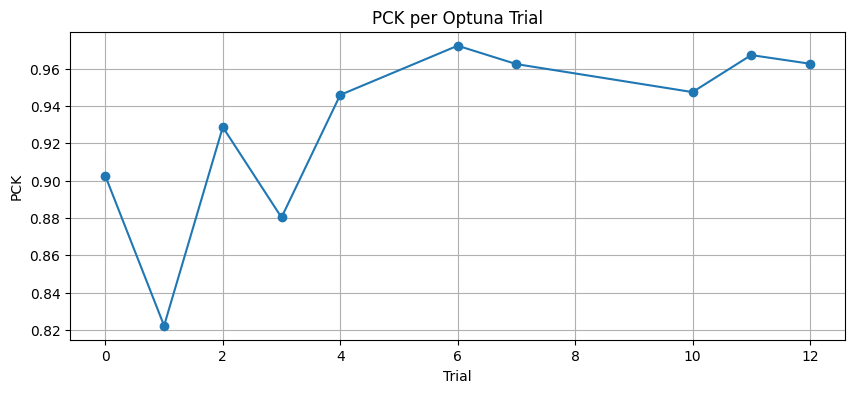

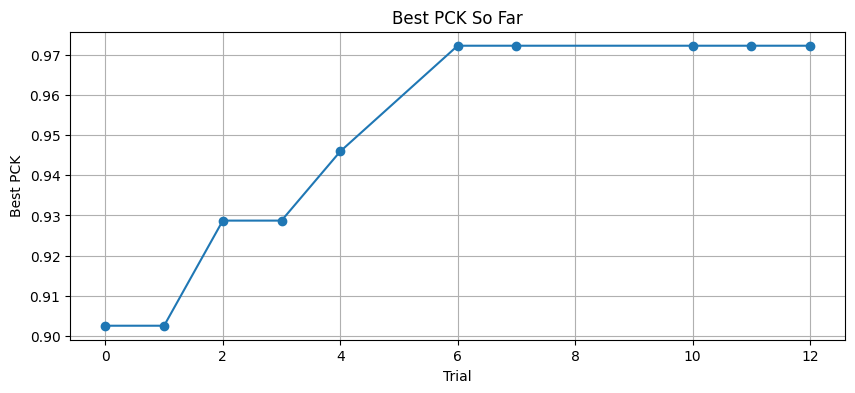

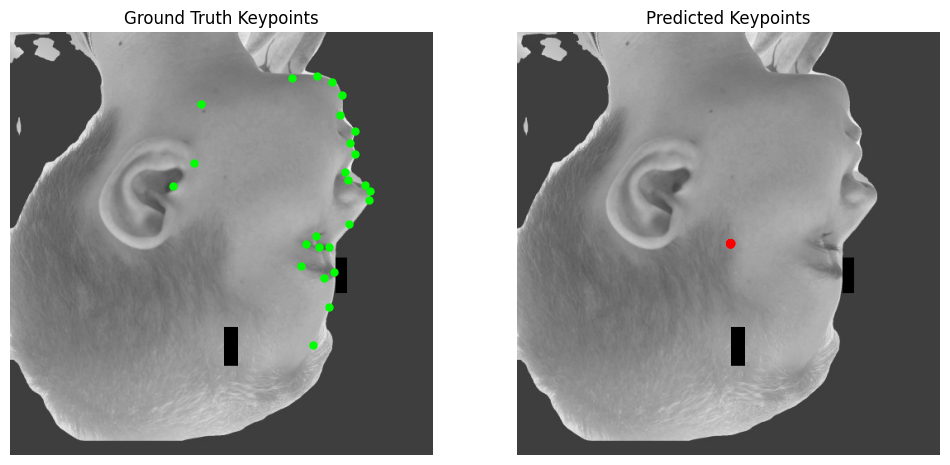

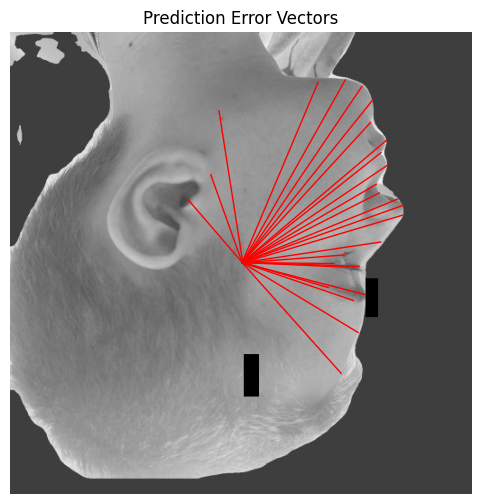

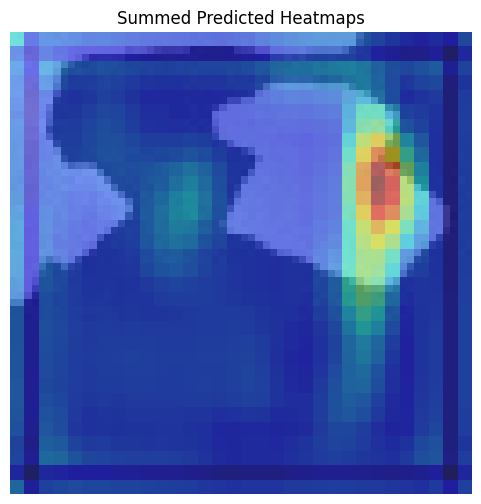

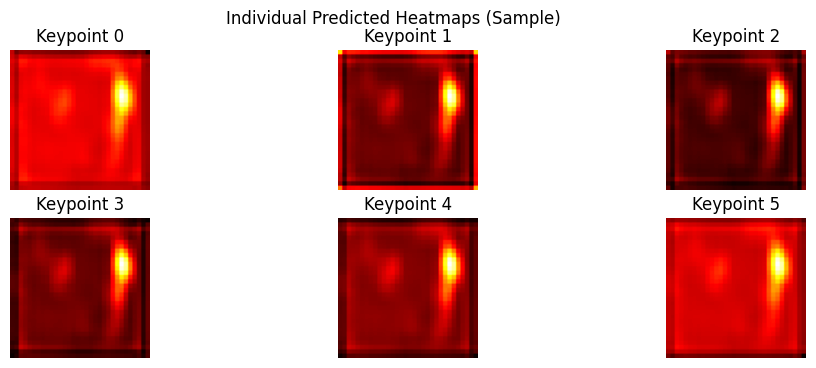

In [7]:
# ============================================================
# POST-TRAINING VISUALIZATION BLOCK
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from torchvision import models
from sklearn.model_selection import GroupKFold

# ============================================================
# CONFIG (MUST MATCH TRAINING)
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_KPTS = 26
IMG_SIZE = 512
HM_SIZE = 64

NPZ_PATH = Path("/kaggle/input/facepoint-detection/kaggle/working/preprocessed/augmented/train/annotations.npz")
RUN_DIR = Path("/kaggle/working/final_kp_run")
CSV_LOG = RUN_DIR / "optuna_log.csv"
MODEL_PATH = RUN_DIR / "best_model.pth"

# ============================================================
# 1. PLOT OPTUNA / TRAINING CURVES
# ============================================================
df = pd.read_csv(CSV_LOG)

plt.figure(figsize=(10,4))
plt.plot(df["trial"], df["pck"], marker="o")
plt.title("PCK per Optuna Trial")
plt.xlabel("Trial")
plt.ylabel("PCK")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["trial"], df["pck"].cummax(), marker="o")
plt.title("Best PCK So Far")
plt.xlabel("Trial")
plt.ylabel("Best PCK")
plt.grid(True)
plt.show()

# ============================================================
# 2. MODEL DEFINITION (EXACT MATCH)
# ============================================================
class Head(nn.Module):
    def __init__(self, c, k):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, k, 1)
        )
    def forward(self, x): 
        return self.net(x)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        m = models.mobilenet_v3_large(weights=None)
        c = m.features[0][0]

        g = nn.Conv2d(
            1, c.out_channels,
            kernel_size=c.kernel_size,
            stride=c.stride,
            padding=c.padding,
            bias=(c.bias is not None)
        )
        m.features[0][0] = g

        self.backbone = m.features
        self.head = Head(960, NUM_KPTS)

    def forward(self, x):
        return torch.sigmoid(self.head(self.backbone(x)))

def softargmax(hm, T=20.0):
    B, K, H, W = hm.shape
    p = F.softmax(hm.view(B, K, -1) * T, dim=2).view(B, K, H, W)
    xs = torch.linspace(0, 1, W, device=hm.device)
    ys = torch.linspace(0, 1, H, device=hm.device)
    x = (p * xs.view(1,1,1,W)).sum((2,3))
    y = (p * ys.view(1,1,H,1)).sum((2,3))
    return torch.stack([x, y], -1)

# Load model
model = Net().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ============================================================
# 3. LOAD DATA & PICK VALIDATION SAMPLE
# ============================================================
data = np.load(NPZ_PATH, allow_pickle=True)
images = data["images"]
keypoints = data["keypoints"]
files = data["filenames"]

groups = np.array([
    str(f).split("_aug")[0] if "_aug" in str(f) else Path(str(f)).stem
    for f in files
])

gkf = GroupKFold(5)
_, val_idx = next(gkf.split(range(len(images)), groups=groups))

idx = np.random.choice(val_idx)
img = images[idx]
kps = keypoints[idx]

img_t = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0) / 255.0
img_t = img_t.to(DEVICE)

# ============================================================
# 4. INFERENCE
# ============================================================
with torch.no_grad():
    hm_pred = model(img_t)
    xy_pred = softargmax(hm_pred)[0].cpu().numpy()

xy_gt = kps[:, :2]
vis = kps[:, 2] > 0

# ============================================================
# 5. IMAGE + KEYPOINTS (GT vs PRED)
# ============================================================
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.scatter(xy_gt[vis,0]*IMG_SIZE, xy_gt[vis,1]*IMG_SIZE,
            c="lime", s=25)
plt.title("Ground Truth Keypoints")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img, cmap="gray")
plt.scatter(xy_pred[vis,0]*IMG_SIZE, xy_pred[vis,1]*IMG_SIZE,
            c="red", s=25)
plt.title("Predicted Keypoints")
plt.axis("off")

plt.show()

# ============================================================
# 6. ERROR VECTORS (GT → PRED)
# ============================================================
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
for i in np.where(vis)[0]:
    x1,y1 = xy_gt[i] * IMG_SIZE
    x2,y2 = xy_pred[i] * IMG_SIZE
    plt.plot([x1,x2],[y1,y2],'r-', linewidth=1)
plt.title("Prediction Error Vectors")
plt.axis("off")
plt.show()

# ============================================================
# 7. HEATMAP VISUALIZATION
# ============================================================
hm = hm_pred[0].cpu().numpy()

# Summed heatmap overlay
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(hm.sum(0), cmap="jet", alpha=0.5)
plt.title("Summed Predicted Heatmaps")
plt.axis("off")
plt.show()

# Individual keypoint heatmaps (first 6)
plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(hm[i], cmap="hot")
    plt.title(f"Keypoint {i}")
    plt.axis("off")
plt.suptitle("Individual Predicted Heatmaps (Sample)")
plt.show()
